## Imports

In [132]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import math
import random

## Functions

In [133]:
class Image:
    """class containing matrix resprenting the image and list with all black blocks (pixels)"""
    def __init__(self, matrix):
        self._m = matrix
        self._n = matrix.shape[0]
        self._blocks = self.get_blocks(matrix)

    def get_blocks(self, matrix):
        blocks = []
        for i in range(self.n):
            for j in range(self.n):
                if not matrix[i, j]:
                    blocks.append((i, j))
        return blocks

    def update_block(self, block, destination):
        # change in matrix
        self._m[block[0], block[1]] = True
        self._m[destination[0], destination[1]] = False

        # change in list of blocks
        self._blocks.remove(block)
        self._blocks.append(destination)

    def copy(self):
        new_matrix = self._m.copy()
        return Image(new_matrix)

    @property
    def m(self):
        return self._m

    @property
    def n(self):
        return self._n

    @property
    def blocks(self):
        return self._blocks


def get_random_image(n, density):
    image_matrix = np.random.randint(1, 100, size=(n, n))
    image_matrix = (image_matrix > 100*density)

    image = Image(image_matrix)

    return image


def dist(a, b):
    """distance between two pixels in taxicab metric"""
    return abs(b[0] - a[0]) + abs(b[1] - a[1])


def is_neighbor(a, b, neighborhood_type):
    """ checking whether a and b are neighbors
        neighborhood types:
        
        24 24 24 24 24
        24 8. 4. 8. 24
        24 4. XX 4. 24
        24 8. 4. 8. 24
        24 24 24 24 24
        
    """
    if neighborhood_type == 4:
        return dist(a, b) == 1
    elif neighborhood_type == 8:
        return abs(b[0] - a[0]) <= 1 and abs(b[1] - a[1]) <= 1
    elif neighborhood_type == 24:
        return abs(b[0] - a[0]) <= 2 and abs(b[1] - a[1]) <= 2
    else:
        return False


def anneal(image, t_max, multiplier, iterations, get_energy, arbitrary):
    # frames for animation of image changing
    frames = [image.m]

    # current image
    optimal_image = image.copy()

    # frames for animate energy plot
    energy = get_energy(image)
    energies = [(0, energy)]

    it = 1
    t = t_max
    while it < iterations:
        # looking for block which can be changed
        while True:
            # list of all blocks
            blocks = optimal_image.blocks.copy()
            
            # current block
            block_to_move = random.choice(blocks)
            
            # move to random place or to neighboring one
            if arbitrary:
                destination = block_to_move
                while destination == block_to_move:
                    potential_dest = (np.random.randint(0, image.n-1), np.random.randint(0, image.n-1))
                    if potential_dest not in optimal_image.blocks:
                        destination = potential_dest
                        
            else:
                # updating list beacause if current block has four immediate neighbors, it cannot move
                blocks.remove(block_to_move)

                # possible moves for the block
                moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]

                # place to which the block will move (and flag for the second while (while True))
                destination = block_to_move

                while moves:
                    # getting random move and updating destination
                    move = random.choice(moves)
                    destination = (block_to_move[0] + move[0], block_to_move[1] + move[1])

                    # cheking if destination is proper
                    if destination[0] < 0 or destination[0] >= image.n or destination[1] < 0 or destination[1] >= image.n \
                            or not optimal_image.m[destination[0], destination[1]]:
                        moves.remove(move)
                        destination = block_to_move
                    else:
                        break

            if destination != block_to_move:
                # making new image
                new_image = optimal_image.copy()
                new_image.update_block(block_to_move, destination)

                # getting energy for the new image
                new_energy = get_energy(new_image)

                # checking if new energy is low enough and if yes, updating current optimal image
                if new_energy <= energy or math.e ** ((energy - new_energy) / t) > random.random():
                    optimal_image = new_image
                    energy = new_energy
                    frames.append(new_image.m)
                    energies.append((it, new_energy))

                break

        it += 1
        t *= multiplier

    # last frames for animations
    frames.append(optimal_image.m)
    energies.append((it, energy))

    # returning result and frames for animations
    return optimal_image, frames, energies

## Animation

In [134]:
def get_animation(rand_image, t_max, multiplier, iterations, get_energy, arbitrary=False):
    # plots configurations
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    fig.tight_layout(pad=3.0)

    # annealing
    optimal_image, frames, energies = anneal(rand_image, t_max, multiplier, iterations, get_energy, arbitrary)

    # plots
    image = ax[0].imshow(rand_image.m, cmap=plt.cm.gray)

    ax[0].set_title("Image")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")

    energy_line, = ax[1].plot([], [], 'r-')
    ax[1].set_xlim(0, iterations)
    ax[1].set_ylim(energies[len(energies)-1][1]*1.5, -energies[len(energies)-1][1])
    ax[1].set_title("Energy")
    ax[1].set_xlabel("iterations")
    ax[1].set_ylabel("energy")
    xenergy = []
    yenergy = []

    # function called in every frame of the animation
    def update_path(i):
        frame = frames[int(i)]

        xenergy.append(energies[int(i)][0])
        yenergy.append(energies[int(i)][1])

        image.set_data(frame)
        energy_line.set_data(xenergy, yenergy)

        return image, energy_line

    # animation must be done in other cell so it is necessary to return these values
    return plt, fig, update_path, frames

## Visualizations

<IPython.core.display.Javascript object>


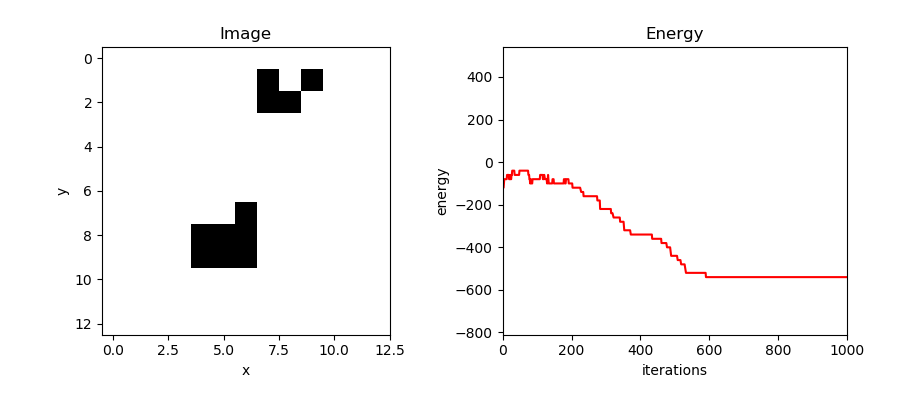

In [159]:
# just 24 neighbors are giving energy and it is the same, NON ARBITRARY move

%matplotlib nbagg

def get_energy(image):
    energy = 0
    for block1 in image.blocks:
        for block2 in image.blocks:
            if block1 != block2:
                if is_neighbor(block1, block2, 4):
                    energy -= 10
                elif is_neighbor(block1, block2, 8):
                    energy -= 10
                elif is_neighbor(block1, block2, 24):
                    energy -= 10

    return energy

size = 13
density = 0.1

t_max = 1000
multiplier = 0.98
iterations = 1000
arbitrary = False

rand_image = get_random_image(size, density)

plt, fig, update_path, frames = get_animation(rand_image, t_max, multiplier, iterations, get_energy, arbitrary)

ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


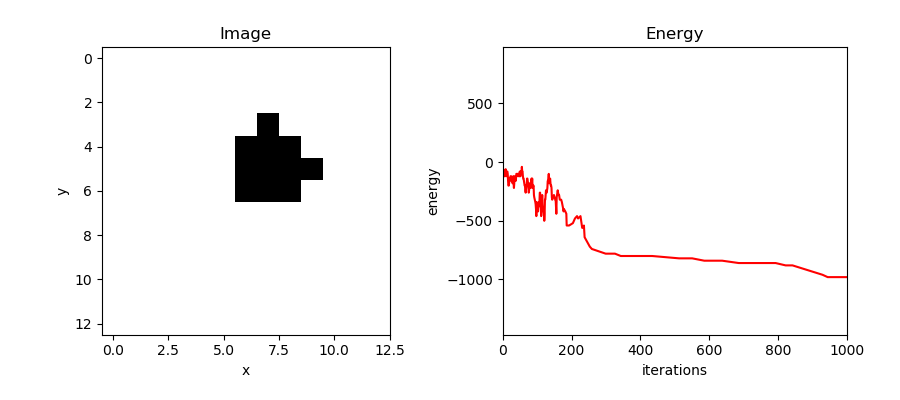

In [161]:
# just 24 neighbors are giving energy and it is the same, ARBITRARY move

%matplotlib nbagg

def get_energy(image):
    energy = 0
    for block1 in image.blocks:
        for block2 in image.blocks:
            if block1 != block2:
                if is_neighbor(block1, block2, 4):
                    energy -= 10
                elif is_neighbor(block1, block2, 8):
                    energy -= 10
                elif is_neighbor(block1, block2, 24):
                    energy -= 10

    return energy

t_max = 1000
multiplier = 0.98
iterations = 1000
arbitrary = True

plt, fig, update_path, frames = get_animation(rand_image, t_max, multiplier, iterations, get_energy, arbitrary)

ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


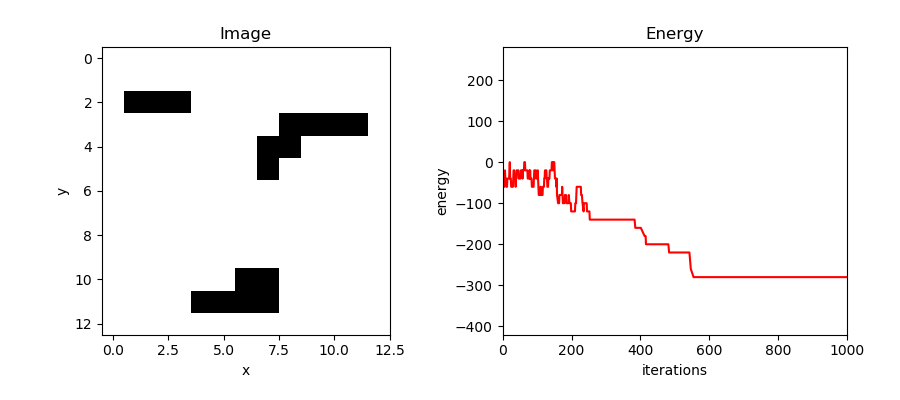

In [163]:
# just 4 neighbors are giving energy and it is the same, NON ARBITRARY move

%matplotlib nbagg

def get_energy(image):
    energy = 0
    for block1 in image.blocks:
        for block2 in image.blocks:
            if block1 != block2:
                if is_neighbor(block1, block2, 4):
                    energy -= 10

    return energy

size = 13
density = 0.1

t_max = 1000
multiplier = 0.98
iterations = 1000
arbitrary = False

rand_image = get_random_image(size, density)

plt, fig, update_path, frames = get_animation(rand_image, t_max, multiplier, iterations, get_energy, arbitrary)

ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


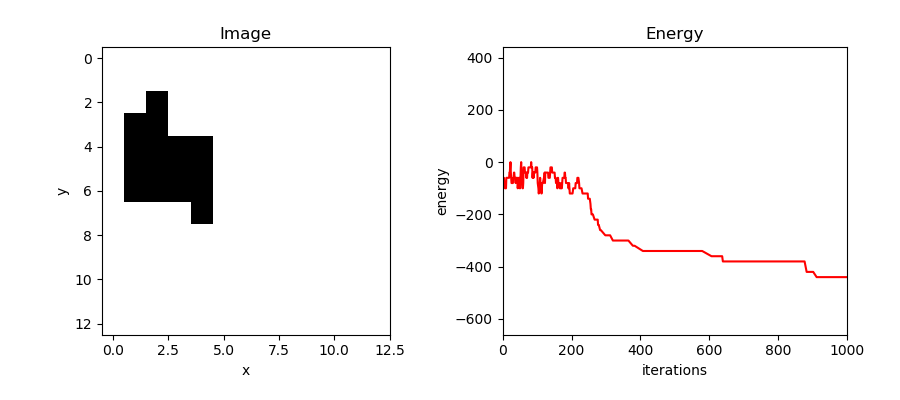

In [165]:
# just 4 neighbors are giving energy and it is the same, ARBITRARY move

%matplotlib nbagg

def get_energy(image):
    energy = 0
    for block1 in image.blocks:
        for block2 in image.blocks:
            if block1 != block2:
                if is_neighbor(block1, block2, 4):
                    energy -= 10

    return energy

t_max = 1000
multiplier = 0.98
iterations = 1000
arbitrary = True

plt, fig, update_path, frames = get_animation(rand_image, t_max, multiplier, iterations, get_energy, arbitrary)

ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


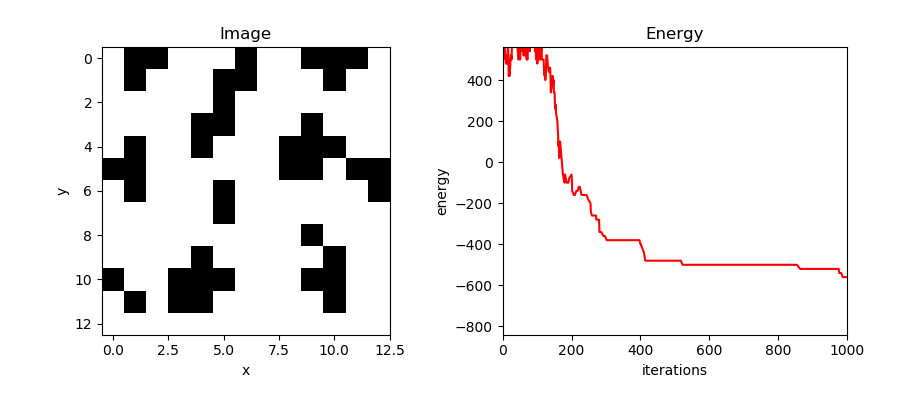

In [167]:
# just 8 neighbors are giving proper (negative) energy and it is the same, next 16 neighbors
# are giving bad (positive) energy, NON ARBITRARY move

%matplotlib nbagg

def get_energy(image):
    energy = 0
    for block1 in image.blocks:
        for block2 in image.blocks:
            if block1 != block2:
                if is_neighbor(block1, block2, 4):
                    energy -= 10
                elif is_neighbor(block1, block2, 8):
                    energy -= 10
                elif is_neighbor(block1, block2, 24):
                    energy += 10

    return energy

size = 13
density = 0.3

t_max = 1000
multiplier = 0.98
iterations = 1000
arbitrary = False

rand_image = get_random_image(size, density)

plt, fig, update_path, frames = get_animation(rand_image, t_max, multiplier, iterations, get_energy, arbitrary)

ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


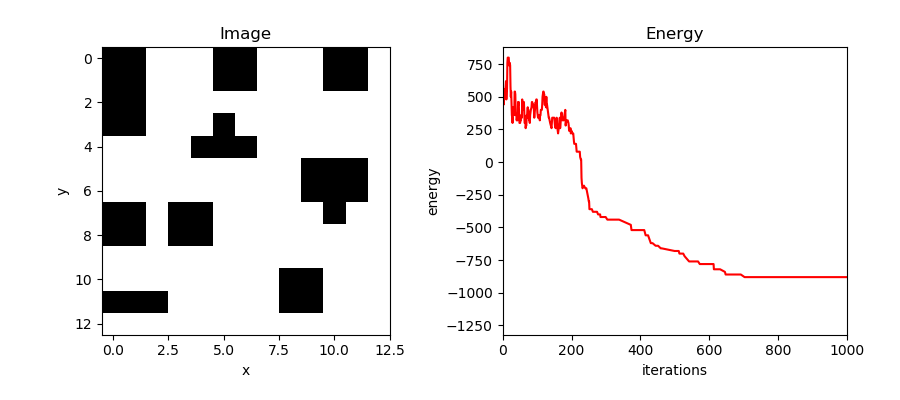

In [169]:
# just 8 neighbors are giving proper (negative) energy and it is the same, next 16 neighbors
# are giving bad (positive) energy, ARBITRARY move

%matplotlib nbagg

def get_energy(image):
    energy = 0
    for block1 in image.blocks:
        for block2 in image.blocks:
            if block1 != block2:
                if is_neighbor(block1, block2, 4):
                    energy -= 10
                elif is_neighbor(block1, block2, 8):
                    energy -= 10
                elif is_neighbor(block1, block2, 24):
                    energy += 10

    return energy

t_max = 1000
multiplier = 0.98
iterations = 1000
arbitrary = True

plt, fig, update_path, frames = get_animation(rand_image, t_max, multiplier, iterations, get_energy, arbitrary)

ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


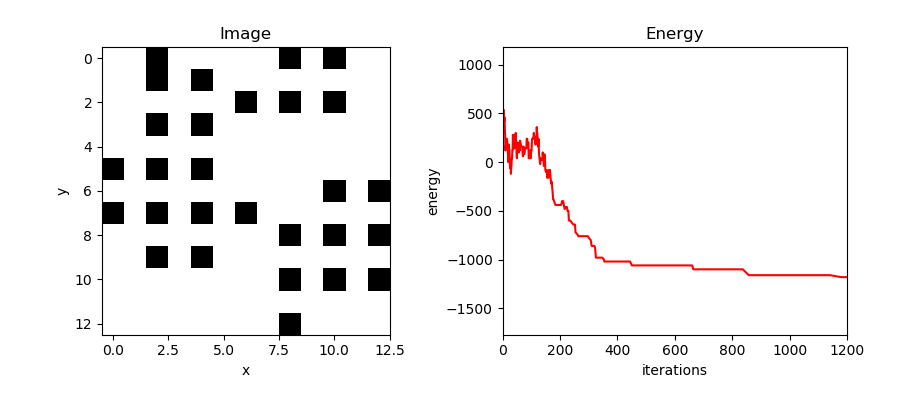

In [188]:
# just further 16 neighbors are giving proper (negative) energy and it is the same, closer 8 neighbors
# are giving bad (positive) energy, NON ARBITRARY move

%matplotlib nbagg

def get_energy(image):
    energy = 0
    for block1 in image.blocks:
        for block2 in image.blocks:
            if block1 != block2:
                if is_neighbor(block1, block2, 4):
                    energy += 30
                elif is_neighbor(block1, block2, 8):
                    energy += 30
                elif is_neighbor(block1, block2, 24):
                    energy -= 10

    return energy

size = 13
density = 0.2

t_max = 1000
multiplier = 0.98
iterations = 1200
arbitrary = False

rand_image = get_random_image(size, density)

plt, fig, update_path, frames = get_animation(rand_image, t_max, multiplier, iterations, get_energy, arbitrary)

ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()

<IPython.core.display.Javascript object>


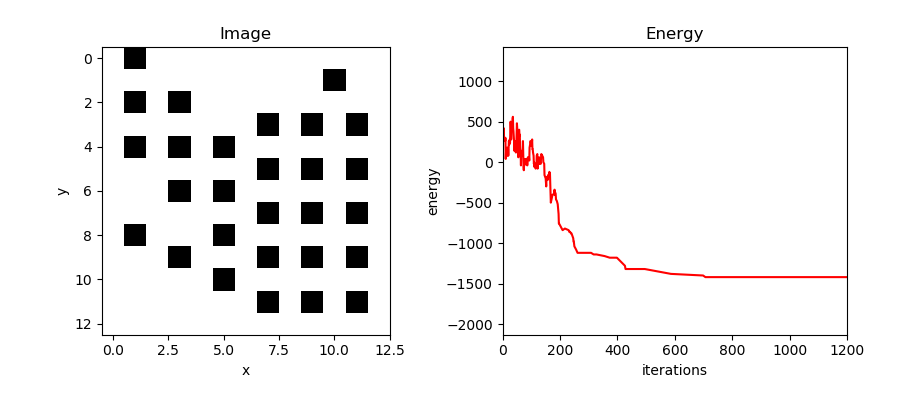

In [190]:
# just further 16 neighbors are giving proper (negative) energy and it is the same, closer 8 neighbors
# are giving bad (positive) energy, ARBITRARY move

%matplotlib nbagg

def get_energy(image):
    energy = 0
    for block1 in image.blocks:
        for block2 in image.blocks:
            if block1 != block2:
                if is_neighbor(block1, block2, 4):
                    energy += 30
                elif is_neighbor(block1, block2, 8):
                    energy += 30
                elif is_neighbor(block1, block2, 24):
                    energy -= 10

    return energy

t_max = 1000
multiplier = 0.98
iterations = 1200
arbitrary = True

plt, fig, update_path, frames = get_animation(rand_image, t_max, multiplier, iterations, get_energy, arbitrary)

ani = animation.FuncAnimation(fig, update_path, frames=np.linspace(0, len(frames)-1, len(frames)),
                              interval=1, repeat=False)

plt.show()